#### @author: Александр Владимирович Толмачев | axtolm@gmail.com
<hr>

## 4. Методы анализа данных на Python

## Часть 3. Классификация с помощью многослойного персептрона

### На этом занятии мы планируем научиться:
- Готовить исходные данные для анализа с помощью нейронных сетей.
- Использовать многослойный персептрон в задаче классификации.
- Получать и интерпретировать показатели эффективности моделей классификации.

### 1. Набор данных для анализа

**Для примера возьмем датасет с открытыми экономическими данными для регионов России, включающими:**<br>
- индекс производства, 
- коэффициент рождаемости организаций,
- коэффициент официальной ликвидации организаций,
- класс региона в зависимости от величины индекса производства (А или В).

**Задача - классифицировать регионы к A или B по величине коэффициентов рождаемости и ликвидации организаций.**

> Файл с данными в формате xlsx прилагается к материалами лекции.<br> 

Загрузим данные из xlsx файла в таблицу `pandas.DataFrame`<br> 

Воспользуемся методом `pandas.read_excel`<br>
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html
<br>Далее ссылки на описание используемых методов будут приведены по ходу лекции.


Если файл находится в той же папке, что документ .ipynb, то путь к нему "С:/DIR/SUBDIR/.../filename.ext" можно не прописывать.<br> 

In [1]:
import pandas as pd                            # импорт библиотеки
in_file_name = "dataset_3_kb_kd_prom_index_2021.xlsx"    # имя файла данных
# загрузка данных в таблицы 
df_in_train = pd.read_excel(in_file_name, sheet_name = "train_01_06_2021", header = 0, index_col = 0)    # для обучения
df_in_test = pd.read_excel(in_file_name, sheet_name = "test_07_2021", header = 0, index_col = 0)         # для тестов

Исходные данные сразу разделены на выборки для обучения и тестирования.<br>
Выборка для обучения - усредненные за период с января по июнь 2021 года. ВЫборка для тестирования - июль 2021 года.<br>

Оценим полученные данные по размеру выборки и первым строкам таблиц

In [2]:
# размеры выборки для обучения и тестирования = кол-ву регионов
print("len(df_in_train) = %s, len(df_in_test) = %s" % (len(df_in_train),len(df_in_test))) 

len(df_in_train) = 85, len(df_in_test) = 85


In [3]:
df_in_train.head(3)    # первые три строки таблицы с данными для обучения

,kb,kd,prom_index,class
region,,,,
Белгородская область,5.783333,13.983333,101.766667,A
Брянская область,3.383333,5.316667,102.300000,A
Владимирская область,3.783333,7.233333,110.616667,A


In [4]:
df_in_test.head(3)    # первые три строки таблицы с данными для тестирования

,kb,kd,prom_index,class
region,,,,
Белгородская область,4.0,14.7,102.5,A
Брянская область,2.2,21.2,108.0,A
Владимирская область,3.6,14.8,109.1,A


**Поля (столбцы) таблиц**<br>
- "region" - название региона,
- "kb" - коэффициент рождаемости организаций (на 1000 организаций),
- "kd" - коэффициент официальной ликвидации организаций (на 1000 организаций),
- "prom_index" - индекс производства, в % к соответствующему периоду прошлого года (период = месяц),
- "class" - class = "A", если prom_index > 100%; class = "B", если prom_index <= 100%. 

### 2. Подготовка данных для анализа

**Сформируем независимую переменную Х из коэффициентов kb и kd**

In [5]:
X_train = df_in_train[['kb','kd']]    # для обучения
X_test = df_in_test[['kb','kd']]      # для тестов

In [6]:
X_train.head(3)    # выведем первые 3 строки таблицы для обучения

,kb,kd
region,,
Белгородская область,5.783333,13.983333
Брянская область,3.383333,5.316667
Владимирская область,3.783333,7.233333


**Сформируем зависимую переменную Y из метки class<br>**

In [7]:
Y_train = df_in_train[['class']]    # для обучения
Y_test = df_in_test[['class']]      # для тестов

In [8]:
Y_train.head(3)    # выведем первые 3 строки таблицы для обучения

,class
region,
Белгородская область,A
Брянская область,A
Владимирская область,A


In [9]:
set(Y_train['class'])    # уникальные значения Y

{'A', 'B'}

**Преобразуем категориальные переменные Y_train и Y_test из строк в числа.**<br>

Воспользуемся библиотекой `sklearn` и модулем `preprocessing` из нее:<br>
https://scikit-learn.org/stable/modules/preprocessing.html<br>
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [10]:
from sklearn import preprocessing    # импорт модуля из библиотеки
lab_encoder = preprocessing.LabelEncoder()    # создадим объект lab_encoder как экземпляр класса preprocessing.LabelEncoder()   
Y_train = Y_train.apply(lab_encoder.fit_transform)    # преобразуем категориальные переменные {A,B} в числа {0,1}
Y_test = Y_test.apply(lab_encoder.fit_transform)

In [11]:
set(Y_train['class'])    # новые уникальные значения Y

{0, 1}

**Стандартизуем (масштабируем) значения X_train и X_test**<br>

Воспользуемся библиотекой `sklearn` и классом `StandardScaler` из нее:<br>
```python
class sklearn.preprocessing.StandardScaler(*, copy=True, with_mean=True, with_std=True)
```
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

> Standardize features by removing the mean and scaling to unit variance.<br>
> The standard score of a sample x is calculated as: `z = (x - u) / s`<br>
> where `u` is the mean of the training samples or zero if `with_mean=False`,<br>
> and `s` is the standard deviation of the training samples or one if `with_std=False`.

In [12]:
from sklearn.preprocessing import StandardScaler    # импорт класса

In [13]:
scaler = StandardScaler(with_mean=True, with_std=True)    # создадим объект scaler как экземпляр класса

In [14]:
scaler.fit(X_train)    # вычисляем mean и std для масштабирования - X_train
X_train = scaler.transform(X_train)    # масштабирование X_train

In [15]:
scaler.fit(X_test)    # вычисляем mean и std для масштабирования - X_test
X_test = scaler.transform(X_test)    # масштабирование X_test

**Визуализируем исходные данные для обучения и оценим перспективы классификации**

**Построим диаграмму рассеяния в осях "kb-kd", выделив цветом принадлежность к классу А или В**<br>
Воспользуемся библиотекой seaborn и методом seaborn.pairplot<br>
https://seaborn.pydata.org/generated/seaborn.pairplot.html

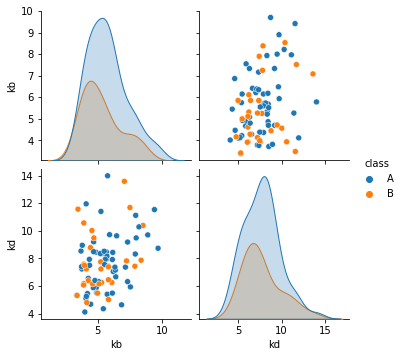

In [16]:
import seaborn as sns
sns.pairplot(df_in_train[['kb','kd','class']], hue = 'class')

**Какие можем сделать выводы?**<br>
Выбранное пространство признаков (рождаемость - ликвидация) **неудачно** для разделения по классам на основе индекса производства.<br> Ожидать выдающихся результатов от нейронной сети в данном случае не стоит.<br>Чем хорош пример? - Тем, что в реальной жизни бывает чаще всего так, а не как в учебных задачах типа ирисов Фишера.

### 3. Многослойный персептрон и задача классификации экономических данных из выборки

Воспользуемся библиотекой:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html

In [17]:
from sklearn.neural_network import MLPClassifier    # импорт класса MLPClassifier

In [18]:
mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=10000, random_state = 11)    # создаем объект mlp как экземпляр класса 

Класс `MLPClassifier` имеет много параметров по умолчанию:<br>  
```python
class sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100,), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)
```
Рассмотрим некоторые:
- **hidden_layer_sizes**: tuple, length = n_layers - 2, default=(100,) - количество нейронов в скрытых слоях, 
- **activation** {‘identity’, ‘logistic’, ‘tanh’, ‘relu’} - функция активации для скрытых слоев, default=’relu’ (the rectified linear unit function) f(x) = max(0, x)
- **solver** {‘lbfgs’, ‘sgd’, ‘adam’} - метод оптимизации весов, default=’adam’ (a stochastic gradient-based optimizer proposed by Kingma, Diederik, ...)
- **max_iter** - максимальное кол-во итераций, default=200
- **random_state**: int, RandomState instance - инициализация генератора случайных чисел, default=None

Мы изменили при создании модели параметры `hidden_layer_sizes`, `max_iter`, `random_state`

**Обучение модели**<br>
Х_train был преобразован в numpy array при масштабировании,<br>
Y_train пока еще DataFrame - преобразуем его прямо тут с помощью методов `to_numpy()` и `ravel()`:<br>
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_numpy.html#pandas.DataFrame.to_numpy
https://numpy.org/doc/stable/reference/generated/numpy.ravel.html

In [19]:
mlp.fit(X_train, Y_train.to_numpy().ravel())    # обучение персептрона

MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=10000, random_state=11)

Проанализируем, как работает обученная сеть на выборке для обучения. Воспользуемся методом predict.

In [20]:
Y_pred_train = mlp.predict(X_train)    # получим классификацию с помощью нейросети на выборке для обучения
Y_pred_train    # выведем на экран

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1])

**Как оценить полученный результат?**<br>
Воспользуемся библиотекой `sklearn` и модулем `metrics`, с помощью которого выведем **матрицу ошибок** и **отчет о классификации**.<br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

In [21]:
from sklearn import metrics    # импорт модуля   
print(metrics.confusion_matrix(Y_train.to_numpy().ravel(), Y_pred_train))    # выведем на экран матрицу ошибок
print(metrics.classification_report(Y_train.to_numpy().ravel(), Y_pred_train))     # выведем отчет о классификации

[[56  0]
 [ 0 29]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        56
           1       1.00      1.00      1.00        29

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



**Что мы видим? Как интерпретировать отчеты?**<br>    
Сначала немного теории, как оценивать результаты классификации<br>    
**I. Confusion Matrix (матрица ошибок)**<br>

|                 |Y actual = 1       |Y actual = 0       |
|-----------------|-------------------|-------------------|  
|Y prediction = 1 |True Positive (TP) |False Positive (FP)|  
|Y prediction = 0 |False Negative (FN)|True Negative (TN) |  

TP — истино-положительное решение,<br>
TN — истино-отрицательное решение,<br>
FP — ложно-положительное решение (ошибка первого рода),<br>
FN — ложно-отрицательное решение (ошибка второго рода).<br>

Чем больше значения на главной диагонали - тем лучше работает модель. Наличие элементов на побочной диагонали говорит об ошибках.

**II. Показатели в metrics.classification_report**<br>   
**Accuracy** — доля правильных ответов: **(TP+TN)/(TP+TN+FP+FN)**<br>   
**Precision (точность)** — **TP/(TP+FP)** и **TN/(TN+FN)**<br>
Эта метрика показывает, насколько мы можем доверять модели, или другими словами, какое у нас количество «ложных срабатываний».<br>Значение метрики равно отношению числа ответов, которые модель считает правильными, и они действительно были правильными (TP) к сумме TP и FP - числа объектов которые модель посчитала правильными, а на самом деле они были неправильные.<br>     
**Recall (полнота)** — **TP/(TP+FN)** и **TN/(TN+FP)**<br>
Эта метрика показывает насколько модель может в принципе обнаруживать правильные ответы, или другими словами, какое у нас количество «ложных пропусков». Ее численное значение равно отношению ответов, которые модель считает правильными, 
и они действительно были правильными (TP) к числу всех правильных ответов в выборке (TP+FN).<br>      
**f1-score (f-мера)** — это объединеный показатель из precision и recall (гармоническое среднее точности и полноты).<br>     
$f_1 = 2\bullet\frac{Precision \bullet Recall}{Precision + Recall}$, если $Precision = 1$ и $Recall = 1$, то $F_1 = 1$<br>     
**support** — число найденных объектов в классе.<br>    

**macro avg** — усредненное значение показателя без учета весов найденных в классах объектов.<br>     
$macro-avg = \frac{1}{2} \bullet score_{class-0} + \frac{1}{2} \bullet score_{class-1}$<br> 

**weighted avg** — усредненное значение показателя с учетом весов найденных в классах объектов.<br>     
$weighted-avg = weight_{class-0} \bullet score_{class-0} +  weight_{class-1} \bullet score_{class-1}$  

Для примера вес класса 0 вычисляется так:
$weight_{class-0} = \frac{support_{class-0}}{support_{class-0} + support_{class-1}}$

### У нас везде 1.0 - значит ли это, что мы получили идеальный результат?

Применим обученную модель к тестовым данным и выведем матрицу ошибок и метрики оценки

In [22]:
Y_pred_test = mlp.predict(X_test)    # получим классификацию с помощью нейросети на выборке для тестирования

In [23]:
print(metrics.confusion_matrix(Y_test.values.ravel(), Y_pred_test))    # выведем на экран матрицу ошибок
print(metrics.classification_report(Y_test.values.ravel(), Y_pred_test))     # выведем отчет о классификации 

[[42 25]
 [11  7]]
              precision    recall  f1-score   support

           0       0.79      0.63      0.70        67
           1       0.22      0.39      0.28        18

    accuracy                           0.58        85
   macro avg       0.51      0.51      0.49        85
weighted avg       0.67      0.58      0.61        85



confusion_matrix показывает матрицу в отличном от вида выше в теории:<br>
>TN FP<br>
>FN TP<br>

precision(class 0) = TN/(TN+FN) = 42/(42+11) = 0.79<br>
recall(class 0) = TN/(TN+FP) = 42/(42+25) = 0.63<br>

### На тестовой выборке результаты далеко не идеальны. Что произошло?

### Overfitting или переобученность сети! 

Сеть с 2-мя входами и 2-мя скрытыми слоями по 50 нейронов в каждом научилась определять все элементы обучающей выборки (а их немного - 85), но сбоит на тестовой, т.к. в этом пространстве признаков классы разделяются плохо.

### 4. Многослойный персептрон и задача классификации ирисов Фишера

**Описание датасета**<br>
Поставляется в составе библиотеки `sklearn` в модуле `datasets`.<br><br>
Ирисы Фишера состоят из данных о 150 экземплярах ириса, по 50 экземпляров из трёх видов:
- Ирис щетинистый (Iris setosa), target = 0
- Ирис разноцветный (Iris versicolor), target = 1  
- Ирис виргинский (Iris virginica), target = 2


Для каждого экземпляра измерялись четыре характеристики (в сантиметрах):
- Длина наружной доли околоцветника (англ. sepal length);
- Ширина наружной доли околоцветника (англ. sepal width);
- Длина внутренней доли околоцветника (англ. petal length);
- Ширина внутренней доли околоцветника (англ. petal width).

На основании этого набора данных требуется построить правило классификации, определяющее вид растения по данным измерений.<br> 
Это задача многоклассовой классификации, так как имеется три класса — три вида ириса. 

In [24]:
from sklearn import datasets    # импорт модуля с данными
import pandas as pd     # импорт библиотеки pandas

Загрузим данные в таблицу `pandas.DataFrame`

In [25]:
iris = datasets.load_iris()     # загрузка данных (массив numpy)
df_iris = pd.DataFrame(iris.data)  # преобразуем в DataFrame, alias pd импортировали в начале
df_iris.columns = iris.feature_names    # делаем имена столбцов такие же, как имена переменных из датасета
df_iris['target'] = iris.target    # добавляем столбец с целевой переменной (класс ириса 0-1-2) 
df_iris['name'] = df_iris.target.apply(lambda x: iris.target_names[x])    # для наглядности добавляем столбец с сортами
df_iris    # выводим начало и конец таблицы

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,virginica
146,6.3,2.5,5.0,1.9,2,virginica
147,6.5,3.0,5.2,2.0,2,virginica
148,6.2,3.4,5.4,2.3,2,virginica


**Построим диаграмму рассеяния в осях пар признаков, выделив цветом принадлежность к тому или иному сорту ирисов.**<br>

Воспользуемся библиотекой seaborn и методом seaborn.pairplot<br>
https://seaborn.pydata.org/generated/seaborn.pairplot.html

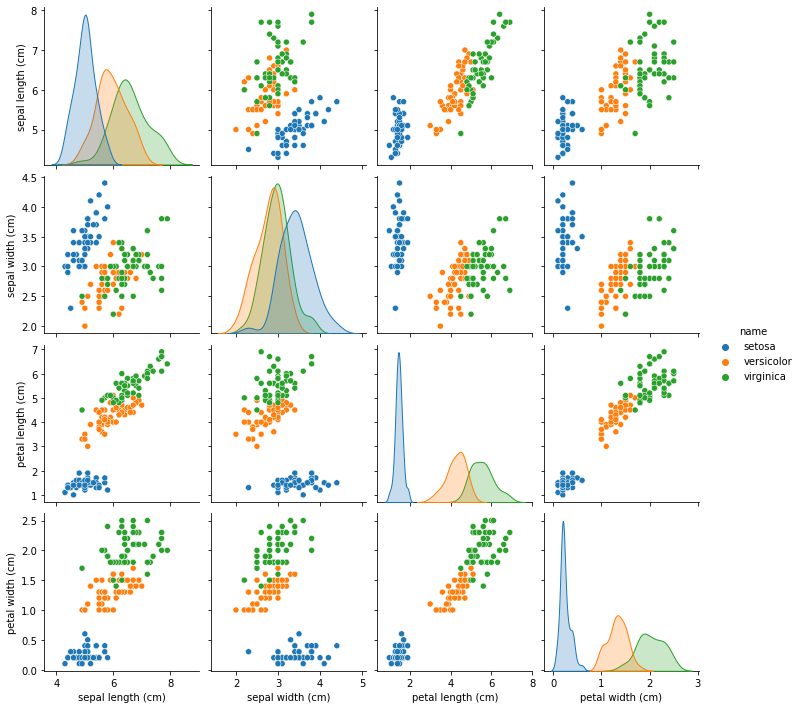

In [26]:
import seaborn as sns
sns.pairplot(df_iris[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)','name']], hue = 'name')

**Что видим?**<br>
**petal width (cm) - petal length (cm)** — точки вытянуты вдоль одной линии, по этим признакам можно строить классификацию.<br>
**sepal width (cm) - sepal length (cm)** — точки Versicolor и Virginica перемешаны между собой, с классификацией проблема.<br>

**Подготовим данные для обучения и тестирования многослойного персептрона**

Выделим выборки для обучения и тестирования из исходного датасета случайным образом в соотношении 70/30.<br>
Воспользуемся библиотекой `sklearn`, модулем `model_selection`, методом `train_test_split`:<br>
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [27]:
from sklearn.model_selection import train_test_split    # импорт метода
# выборки для обучения и тестирования в соотношении 70/30
train_data, test_data, train_labels, test_labels = train_test_split(
    df_iris[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']], 
    df_iris['target'], test_size = 0.3, random_state = 10)

Оценим полученные данные

In [28]:
train_data.head(3)    # независимая переменная X - вектор признаков, по которым делаем классификацию

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
32,5.2,4.1,1.5,0.1
52,6.9,3.1,4.9,1.5
70,5.9,3.2,4.8,1.8


In [29]:
train_labels.head(3)    # метки классов - зависимая переменная Y

32    0
52    1
70    1
Name: target, dtype: int32

In [30]:
print(len(train_data),len(test_data))    # размеры выборок для обучения и тестирования

105 45


**Стандартизуем (масшабируем) значения X для обучения и тестирования так, как делали выше**

In [31]:
from sklearn.preprocessing import StandardScaler    # импорт класса
scaler = StandardScaler(with_mean=True, with_std=True)    # создадим объект как экземпляр импортированнного класса

In [32]:
scaler.fit(train_data)    # вычисляем mean и std для масштабирования - train_data
train_data = scaler.transform(train_data)    # масштабирование train_data

In [33]:
scaler.fit(test_data)    # вычисляем mean и std для масштабирования - test_data
test_data = scaler.transform(test_data)    # масштабирование test_data

**Построим модель многослойного персептрона**

In [34]:
from sklearn.neural_network import MLPClassifier     # импорт класса
mlp = MLPClassifier(hidden_layer_sizes=(50,50), max_iter=10000, random_state = 11)    # создаем объект как экземпляр класса
mlp.fit(train_data, train_labels)    # обучаем его

MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=10000, random_state=11)

**Выполним классификацию тестовых данных (они не использовались при обучении)**

In [35]:
pred_test_labels = mlp.predict(test_data)    # используем для классификации тестовой выборки

In [36]:
# Выведем матрицу ошибок и метрики оценки
from sklearn import metrics 
print(metrics.confusion_matrix(test_labels, pred_test_labels))
print(metrics.classification_report(test_labels, pred_test_labels))

[[13  1  0]
 [ 0 17  0]
 [ 0  0 14]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.94      1.00      0.97        17
           2       1.00      1.00      1.00        14

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



### Как результаты? В учебном примере все хорошо!

### Подведем итоги. На этом занятии мы научились:
- Готовить исходные данные для анализа с помощью нейронных сетей.
- Использовать многослойный персептрон в задаче классификации.
- Получать и интерпретировать показатели эффективности моделей классификации.